In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

In [4]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [5]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [6]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


In [7]:
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}

In [8]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [9]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [10]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    
def build_aspect_dataset(sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=num_workers, worker_init_fn=seed_worker
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=num_workers, worker_init_fn=seed_worker
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [12]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=96):
    aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
    ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4, worker_init_fn=seed_worker,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4, worker_init_fn=seed_worker,
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4, worker_init_fn=seed_worker,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4, worker_init_fn=seed_worker,
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def compute_metrics(p, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [15]:
manager = Manager()

aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()

sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()

accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

In [16]:
def train_model(sequence_length, model_name, aspect_metrics, sentiment_metrics, metrics, seed=42, layers_freezed=6, trials=1):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device
    ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

    # Define model
    aspect_model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(sequence_length)
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(EPOCHS):
        aspect_model.train()
        epoch_loss = 0
        
        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))
                
        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()
        
        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            aspect_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'aspect-model-{sequence_length}-{layers_freezed}-{trials}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    if accelerator.is_main_process:
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'aspect-model-{sequence_length}-{layers_freezed}-{trials}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("-------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(EPOCHS):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        # accelerator.print("Before gathering:", sentiment_val_outputs[0])
        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        # accelerator.print("After gathering:", sentiment_val_outputs[0])
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            ['negative', 'positive']
        )
        
        # result = compute_metrics_sentiment(type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}))

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                f'sentiment-model-{sequence_length}-{layers_freezed}-{trials}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])
    
    if accelerator.is_main_process:
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained(f'sentiment-model-{sequence_length}-{layers_freezed}-{trials}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    # if accelerator.is_main_process:
    with torch.no_grad():
        # x = 0
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("-------------------------")
        accelerator.print(f"Overall accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
            
    
        if accelerator.is_main_process:
            metrics[0].append(result['accuracy'])
            metrics[1].append(result['f1_micro'])
            metrics[2].append(result['f1_macro'])
    
    accelerator.print(f"Total train time: {duration} s")

In [17]:
# Tokenize each text and calculate their lengths
token_lengths = [len(tokenizer.tokenize(text)) for text in X_train]

# Calculate the average length
average_length = sum(token_lengths) / len(token_lengths)
max_length = max(token_lengths)

print("Average length of tokenized text:", average_length)
print("Max token length:", max_length)

Average length of tokenized text: 16.21759259259259
Max token length: 55


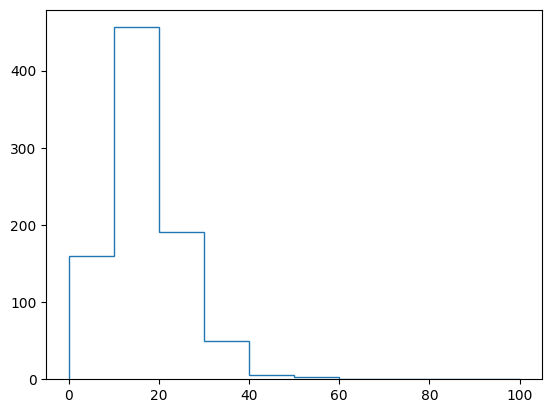

In [18]:
counts, bins = np.histogram(token_lengths, range=(0, 100))
plt.stairs(counts, bins)
plt.show()

# HYPERPARAMETER TUNING

In [19]:
sizes = [8, 16]
lengths = [24, 32, 40, 48]

used_sizes = []
used_lengths = []

for size in sizes:
    BATCH_SIZE = size
    for length in lengths:
        print("=========================================================================================")
        print(f"Batch size: {BATCH_SIZE}, sequence length: {length}")
        used_sizes.append(BATCH_SIZE)
        used_lengths.append(length)
        
        args = (
            length, 
            'indobenchmark/indobert-base-p1', 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros), 
            (accuracies, f1_micros, f1_macros), 
            42, 
            6,
            1
        )
        notebook_launcher(train_model, args, num_processes=2)

Batch size: 8, sequence length: 24
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4847, Accuracy: 0.881, F1 Micro: 0.9294, F1 Macro: 0.9279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2755, Accuracy: 0.9524, F1 Micro: 0.9706, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1645, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9747
Epoch 4/10, Train Loss: 0.1196, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9733
Epoch 5/10, Train Loss: 0.0838, Accuracy: 0.9539, F1 Micro: 0.9708, F1 Macro: 0.9677
Epoch 6/10, Train Loss: 0.0624, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9705
Epoch 7/10, Train Loss: 0.0488, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9716
Epoch 8/10, Train Loss: 0.0402, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9736

As

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4004, Accuracy: 0.8906, F1 Micro: 0.8906, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2003, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1206, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9274
Epoch 5/10, Train Loss: 0.1072, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9207
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0843, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9349
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9184
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9258
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9233
Epoch 10/10, Train Loss: 0.0582, Accuracy: 0.8945, F1 Micro: 0.8945, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4826, Accuracy: 0.8854, F1 Micro: 0.932, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9539, F1 Micro: 0.9715, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1554, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9742
Epoch 4/10, Train Loss: 0.1094, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Epoch 5/10, Train Loss: 0.0831, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9732
Epoch 6/10, Train Loss: 0.0588, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9719
Epoch 7/10, Train Loss: 0.0458, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0401, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9776
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 10/10, Train Loss: 0.0273, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751

A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4077, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9109
Epoch 2/10, Train Loss: 0.2108, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8919
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1589, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9158
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0896, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9132
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0803, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9169
Epoch 6/10, Train Loss: 0.0807, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9146
Epoch 7/10, Train Loss: 0.0579, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8998
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.9051
Epoch 9/10, Train Loss: 0.0785, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.902
Epoch 10/10, Train Loss: 0.0669, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.901

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4791, Accuracy: 0.9025, F1 Micro: 0.9415, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2614, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1516, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1125, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9755
Epoch 5/10, Train Loss: 0.0832, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0586, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.0451, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0377, Accuracy: 0.9695, F1 Micro: 0.9807, F1 Macro: 0.9795
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9792
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.401, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1925, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9133
Epoch 3/10, Train Loss: 0.1497, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8988
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1116, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0962, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9208
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9149
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.894
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9356
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.9099
Epoch 10/10, Train Loss: 0.0464, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4801, Accuracy: 0.8988, F1 Micro: 0.9393, F1 Macro: 0.938
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.265, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1515, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9771
Epoch 4/10, Train Loss: 0.1115, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Epoch 5/10, Train Loss: 0.0769, Accuracy: 0.9635, F1 Micro: 0.9768, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0567, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9808
Epoch 7/10, Train Loss: 0.0471, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 8/10, Train Loss: 0.0385, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9807
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.9717, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3811, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2139, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1556, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Epoch 4/10, Train Loss: 0.1113, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.9063
Epoch 5/10, Train Loss: 0.0942, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9099
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9168
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9159
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Epoch 10/10, Train Loss: 0.0443, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8933

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5196, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3849, Accuracy: 0.933, F1 Micro: 0.9588, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2492, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4657, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9356
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1839, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9489
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9404
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9315
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9205
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9225
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9048
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9271
Epoch 10/10, Train Loss: 0.0525, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9238

Sentiment analysis accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9489
           

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5178, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3801, Accuracy: 0.933, F1 Micro: 0.9587, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2421, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9753
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0556, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5134, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.9039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2534, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9404
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9238
Epoch 4/10, Train Loss: 0.1162, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9092
Epoch 5/10, Train Loss: 0.1075, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9398
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9275
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9238
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9308
Epoch 10/10, Train Loss: 0.0527, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9175

Sentiment analysis accuracy: 0.9466, F1 Micro: 0.946

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5184, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3793, Accuracy: 0.9338, F1 Micro: 0.9592, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2412, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.9786
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0548, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4997, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9224
Epoch 2/10, Train Loss: 0.222, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9205
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9579, F1 Micro: 0.9579, F1 Macro: 0.9519
Epoch 6/10, Train Loss: 0.1052, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.9002
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9464, F1 Micro: 0.9464, F1 Macro: 0.9397
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9081
Epoch 10/10, Train Loss: 0.0542, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9269

Sentiment analysis accuracy: 0.9579, F1 Micro: 0.9579, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5176, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3793, Accuracy: 0.9315, F1 Micro: 0.9578, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2426, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9781
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9802
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9799
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4892, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9375
Epoch 2/10, Train Loss: 0.2228, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9409
Epoch 4/10, Train Loss: 0.1254, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9263
Epoch 5/10, Train Loss: 0.0898, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9288
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9248
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9208
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9227
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9331
Epoch 10/10, Train Loss: 0.0652, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9227

Sentiment analysis accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9409
            

In [20]:
results = pd.DataFrame({
    'Batch Size': used_sizes,
    'Sequence Length': used_lengths,
    'Aspect Accuracy': list(aspect_accuracies),
    'Aspect F1 Micro': list(aspect_f1_micros),
    'Aspect F1 Macro': list(aspect_f1_macros),
    'Sentiment Accuracy': list(sentiment_accuracies),
    'Sentiment F1 Micro': list(sentiment_f1_micros),
    'Sentiment F1 Macro': list(sentiment_f1_macros),
    'Accuracy': list(accuracies),
    'F1 Micro': list(f1_micros),
    'F1 Macro': list(f1_macros),
})

results.to_csv(f'casa-hyperparameters-tuning.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

trial = 1
for seed in seeds:
    print("=====================")
    print("SEED:", seed)
    set_seed(seed)
    
    LEARNING_RATE = 2e-5
    BATCH_SIZE = 16
    args = (
        48, 
        'indobenchmark/indobert-base-p1', 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros), 
        (accuracies, f1_micros, f1_macros), 
        42, 
        6,
        trial
    )
    
    notebook_launcher(train_model, args, num_processes=2)

    trial += 1

SEED: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5299, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3822, Accuracy: 0.9323, F1 Micro: 0.958, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2439, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9773
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.9788
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macro: 0.9819
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.428, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2304, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9227
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9171
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.142, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9402
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9347
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9317
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0634, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.514, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3581, Accuracy: 0.9308, F1 Micro: 0.9571, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2294, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9742
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.9673, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5153, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8761
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2103, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9112
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1552, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9194
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9152
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9183
Epoch 6/10, Train Loss: 0.1304, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9241
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9197
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0549, Accuracy: 0.931, F1 Micro: 0.931, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5188, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3845, Accuracy: 0.9293, F1 Micro: 0.9566, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2448, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9767
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9786
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9749
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4655, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8992
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.9549, F1 Micro: 0.9549, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9549, F1 Micro: 0.9549, F1 Macro: 0.9499
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9317
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9511, F1 Micro: 0.9511, F1 Macro: 0.9459
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9101
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9335
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9339
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9378
Epoch 10/10, Train Loss: 0.0608, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9369

Sentiment analysis accuracy: 0.9549, F1 Micro: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5216, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4066, Accuracy: 0.9182, F1 Micro: 0.95, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2495, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4899, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2198, Accuracy: 0.942, F1 Micro: 0.942, F1 Macro: 0.9355
Epoch 3/10, Train Loss: 0.1584, Accuracy: 0.9348, F1 Micro: 0.9348, F1 Macro: 0.9262
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9348, F1 Micro: 0.9348, F1 Macro: 0.9266
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9384, F1 Micro: 0.9384, F1 Macro: 0.928
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9384, F1 Micro: 0.9384, F1 Macro: 0.9297
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9348, F1 Micro: 0.9348, F1 Macro: 0.9274
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.9009
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.942, F1 Micro: 0.942, F1 Macro: 0.9341
Epoch 10/10, Train Loss: 0.067, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.9037

Sentiment analysis accuracy: 0.942, F1 Micro: 0.942, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5215, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4041, Accuracy: 0.9249, F1 Micro: 0.9539, F1 Macro: 0.9525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2564, Accuracy: 0.9591, F1 Micro: 0.9746, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0519, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4422, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9448
Epoch 3/10, Train Loss: 0.154, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9269
Epoch 4/10, Train Loss: 0.1267, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9369
Epoch 5/10, Train Loss: 0.0869, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9289
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9249
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9314
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9403
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9157
Epoch 10/10, Train Loss: 0.0457, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9282

Sentiment analysis accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9448
             

In [22]:
results = pd.DataFrame({
    'Trial': [1,2,3,4,5],
    'Aspect Accuracy': list(aspect_accuracies),
    'Aspect F1 Micro': list(aspect_f1_micros),
    'Aspect F1 Macro': list(aspect_f1_macros),
    'Sentiment Accuracy': list(sentiment_accuracies),
    'Sentiment F1 Micro': list(sentiment_f1_micros),
    'Sentiment F1 Macro': list(sentiment_f1_macros),
    'Accuracy': list(accuracies),
    'F1 Micro': list(f1_micros),
    'F1 Macro': list(f1_macros),
})

results.to_csv(f'casa-passive-results.csv', index=False)